# Identifying Enron POI

In [1]:
%%javascript
IPython.notebook.config.update({
  "load_extensions": {"calico-spell-check":true,
                      "calico-document-tools":true,
                      "calico-cell-tools":true
                     }
})

<IPython.core.display.Javascript object>

*Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it*

We are looking at the data obtained from the Enron court proceedings and are trying to identify persons of interest in the fraud case using machine learning. Enron is a company that essentially collapsed under the weight of their own fraudulent schemes and was shut down by the SEC.


In [63]:
import sys
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import tester
import seaborn as sns
sns.set_palette("hls", 2)
import numpy as np
sys.path.append("../tools/")
%matplotlib inline


from feature_format import featureFormat, targetFeatureSplit

## Exploration 

We begin by loading the dataset

In [64]:
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
df = pd.DataFrame().from_dict(data_dict).T
df.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
ALLEN PHILLIP K,4175000,2869717,-3081055,NaN,phillip.allen@enron.com,1729541,13868,2195,47,65,...,304805,152,False,126027,-126027,201955,1407,2902,4484442,1729541
BADUM JAMES P,NaN,178980,NaN,NaN,NaN,257817,3486,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,182466,257817
BANNANTINE JAMES M,NaN,NaN,-5104,NaN,james.bannantine@enron.com,4046157,56301,29,39,0,...,NaN,864523,False,1757552,-560222,477,465,566,916197,5243487
BAXTER JOHN C,1200000,1295738,-1386055,NaN,NaN,6680544,11200,NaN,NaN,NaN,...,1586055,2660303,False,3942714,NaN,267102,NaN,NaN,5634343,10623258
BAY FRANKLIN R,400000,260455,-201641,NaN,frank.bay@enron.com,NaN,129142,NaN,NaN,NaN,...,NaN,69,False,145796,-82782,239671,NaN,NaN,827696,63014


In [65]:
len(df)

146

In [66]:
df = df.replace("NaN", np.nan)
df.describe().T.sort_values(["count"])

,count,mean,std,min,25%,50%,75%,max
loan_advances,4.0,4.196250e+07,4.708321e+07,400000.0,1600000.00,41762500.0,82125000.00,83925000.0
director_fees,17.0,1.668049e+05,3.198914e+05,3285.0,98784.00,108579.0,113784.00,1398517.0
restricted_stock_deferred,18.0,1.664106e+05,4.201494e+06,-7576788.0,-389621.75,-146975.0,-75009.75,15456290.0
deferral_payments,39.0,1.642674e+06,5.161930e+06,-102500.0,81573.00,227449.0,1002671.50,32083396.0
deferred_income,49.0,-1.140475e+06,4.025406e+06,-27992891.0,-694862.00,-159792.0,-38346.00,-833.0
long_term_incentive,66.0,1.470361e+06,5.942759e+06,69223.0,281250.00,442035.0,938672.00,48521928.0
bonus,82.0,2.374235e+06,1.071333e+07,70000.0,431250.00,769375.0,1200000.00,97343619.0
from_poi_to_this_person,86.0,6.489535e+01,8.697924e+01,0.0,10.00,35.0,72.25,528.0
from_this_person_to_poi,86.0,4.123256e+01,1.000731e+02,0.0,1.00,8.0,24.75,609.0
shared_receipt_with_poi,86.0,1.176465e+03,1.178318e+03,2.0,249.75,740.5,1888.25,5521.0


The least populated column in our dataset is loan_advances with a mere 4 values. The second and third least populated columns are director_fees and restricted_stock_deferred with 17 and 18 values respectively.

In [67]:
nan_rows = df.isnull().sum(axis=1).sort_values(ascending=False)
df.loc[nan_rows.index.values[:10]]

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
LOCKHART EUGENE E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GRAMM WENDY L,NaN,NaN,NaN,119292.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,119292.0,NaN
WROBEL BRUCE,NaN,NaN,NaN,NaN,NaN,139130.0,NaN,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,139130.0
WHALEY DAVID A,NaN,NaN,NaN,NaN,NaN,98718.0,NaN,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,98718.0
THE TRAVEL AGENCY IN THE PARK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,362096.0,False,NaN,NaN,NaN,NaN,NaN,362096.0,NaN
WAKEHAM JOHN,NaN,NaN,NaN,109298.0,NaN,NaN,103773.0,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,213071.0,NaN
WODRASKA JOHN,NaN,NaN,NaN,NaN,john.wodraska@enron.com,NaN,NaN,NaN,NaN,NaN,...,NaN,189583.0,False,NaN,NaN,NaN,NaN,NaN,189583.0,NaN
CLINE KENNETH W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,662086.0,-472568.0,NaN,NaN,NaN,NaN,189518.0
GILLIS JOHN,NaN,NaN,NaN,NaN,NaN,9803.0,NaN,NaN,NaN,NaN,...,NaN,NaN,False,75838.0,NaN,NaN,NaN,NaN,NaN,85641.0
SCRIMSHAW MATTHEW,NaN,NaN,NaN,NaN,matthew.scrimshaw@enron.com,759557.0,NaN,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,759557.0


From the least populated rows one stands out. *THE TRAVEL AGENCY IN THE PARK*	doesn't seem to be a person so we should drop it from the dataset.

In [68]:
df = df.drop("THE TRAVEL AGENCY IN THE PARK")
len(df.columns.values)

21

The dataset contains 21 columns, which means there will be 19 features as one column is the POI label and one is the email address field.

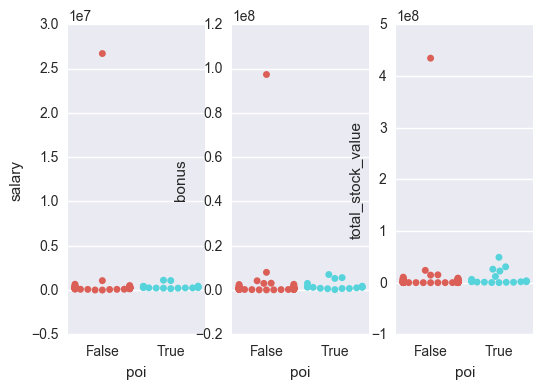

In [69]:
fig, axs = plt.subplots(ncols=3)
sns.swarmplot(x="poi", y="salary", data=df, ax=axs[0])
sns.swarmplot(x="poi", y="bonus", data=df, ax=axs[1])
sns.swarmplot(x="poi", y="total_stock_value", data=df, ax=axs[2])

In [70]:
df[(df.salary == df.salary.max()) & (df.poi == False)].index.values

array(['TOTAL'], dtype=object)

Upon plotting the values of a few select columns, we find that there is a big outlier in the dataset. It is the TOTAL row, which we should drop. Plotting distributions again:

In [71]:
df = df.drop("TOTAL")

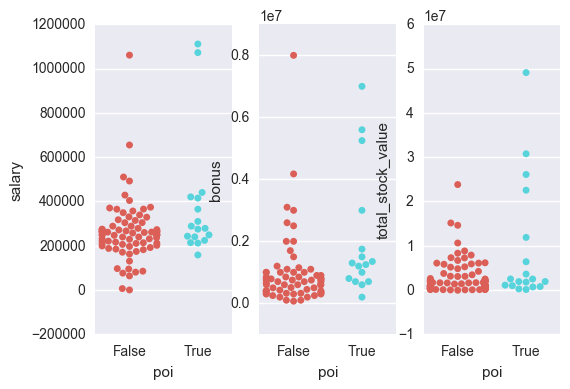

In [72]:
fig, axs = plt.subplots(ncols=3)
sns.swarmplot(x="poi", y="salary", data=df, ax=axs[0])
sns.swarmplot(x="poi", y="bonus", data=df, ax=axs[1])
sns.swarmplot(x="poi", y="total_stock_value", data=df, ax=axs[2])

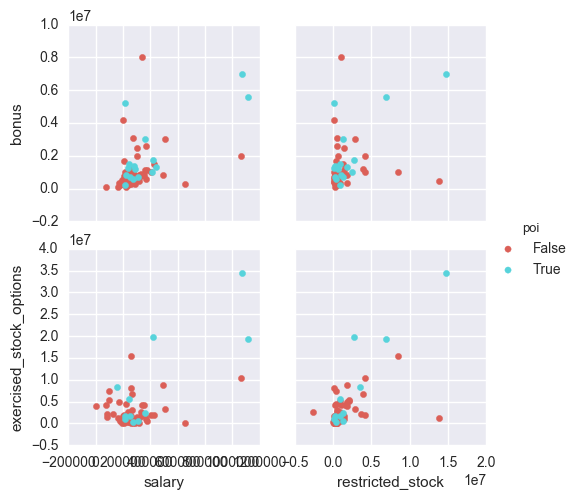

In [73]:
g = sns.PairGrid(df, x_vars=["salary", "restricted_stock"], y_vars=["bonus", "exercised_stock_options"], hue="poi")
g.map(plt.scatter)
g.add_legend()

In [74]:
print df["poi"].value_counts()
print len(df)

False    126
True      18
Name: poi, dtype: int64
144


### Summary of Exploration
The uncleaned data set contains __146 data points__/persons.
After cleaning, two points are removed bringing the total count to __144__.
Of those are __124 non-POI__ and and __18 POI__. When graphing the data some POI clearly stand out while others fall into the same cluster as non-POI.
There are __19 features__ to choose from (excluding the POI label itself and email address).

## Feature Engineering
The following snippet engineers three features:

#### Undeferred Restricted Stock
A few people in the data set have voluntarily deferred their restricted stock, which means they are entitled to it in the future rather than now. Maybe that would influence their decision process towards longer term thinking.

#### Fraction from and to POI
Indicates the intensity of correspondence between this person and a POI. People interacting with POI a lot may be POI themselves.

#### Fraction shared with POI
Share of to messages that have been sent to a POI where the person was CC'ed. 


In [75]:
df["restricted_stock"].fillna(0, inplace=True)
df["restricted_stock_deferred"].fillna(0, inplace=True)
df["to_messages"].fillna(0, inplace=True)
df["from_messages"].fillna(0, inplace=True)

df["undeferred_restricted_stock"] = df["restricted_stock"] + df["restricted_stock_deferred"]

def calc_frac_poi(row):
    frac_from = 0.
    frac_to = 0.
    frac_shared = 0.
    if row['to_messages'] != 0:
        frac_from = float(row["from_poi_to_this_person"]) / row['to_messages']
        frac_shared = float(row["shared_receipt_with_poi"]) / row['to_messages']
    if row['from_messages'] != 0:
        frac_to = float(row['from_this_person_to_poi']) / row["from_messages"]

    row["fraction_to_poi"] = frac_to
    row["fraction_from_poi"] = frac_from
    row["fraction_shared_with_poi"] = frac_shared
    return row
    
df = df.apply(calc_frac_poi, axis=1)
df[df["from_poi_to_this_person"] > 0].sort_values("fraction_from_poi").tail(5)

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,undeferred_restricted_stock,fraction_to_poi,fraction_from_poi,fraction_shared_with_poi
DIETRICH JANET R,600000.0,NaN,NaN,NaN,janet.dietrich@enron.com,1550019.0,3475.0,63.0,305.0,14.0,...,0.0,250100.0,1902.0,2572.0,1410464.0,1865087.0,315068.0,0.222222,0.118585,0.739502
REDMOND BRIAN L,NaN,NaN,NaN,NaN,brian.redmond@enron.com,7509039.0,14689.0,221.0,204.0,49.0,...,0.0,96840.0,1063.0,1671.0,111529.0,7890324.0,381285.0,0.221719,0.122083,0.636146
COLWELL WESLEY,1200000.0,27610.0,-144062.0,NaN,wes.colwell@enron.com,NaN,16514.0,40.0,240.0,11.0,...,0.0,288542.0,1132.0,1758.0,1490344.0,698242.0,698242.0,0.275000,0.136519,0.643914
DEFFNER JOSEPH M,600000.0,NaN,NaN,NaN,joseph.deffner@enron.com,17378.0,41626.0,74.0,115.0,4.0,...,0.0,206121.0,552.0,714.0,1208649.0,159211.0,141833.0,0.054054,0.161064,0.773109
DONAHUE JR JEFFREY M,800000.0,NaN,-300000.0,NaN,jeff.donahue@enron.com,765920.0,96268.0,22.0,188.0,11.0,...,0.0,278601.0,772.0,865.0,875760.0,1080988.0,315068.0,0.500000,0.217341,0.892486


## Feature Selection

I will opt for automatic feature selection later on. Therefore initially all features (except the email address) are selected including my newly engineered features.

In [76]:
financial_features = ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees']
email_features = ['to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']
all_features = financial_features + email_features

features_list = ['poi'] + all_features + ['undeferred_restricted_stock', 'fraction_from_poi', 'fraction_to_poi', 'fraction_shared_with_poi']

print len(features_list)

my_dataset = df.replace(np.nan, 0).T.to_dict() # replace nans with zeroes so feature format works
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

24


## Cross Validation
For cross validation I will use the StratifiedKFold method. Cross validation is important because of overfitting. If a model is not properly cross validated then it may prove to be unreliable in classifying real world/unseen data. I read in the sklearn documentation that 5-10 splits are recommended.

In [77]:
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, StratifiedShuffleSplit

cv = StratifiedKFold(n_splits=6, random_state=42)

## Naive Bayes with PCA
For my first try I will attempt to find a good scoring pipeline. I will use the StandardScaler as standardising data is recommended when using PCA especially because we are using features with different scales (eg salary vs frac_from_poi). After a few tries I found that recall was hardest to achieve which is why I score by recall, hoping that if recall is above .3 precision will be as well. In this code I let GridSearchCV tune the k parameter to select the best k features to use in combination with PCA which will apply dimensionality reduction before passing the results into GaussianNB or SVC.
For GaussianNB there are no parameters. For SVC I tune the C and gamma, C being the trade-off between misclassifications and decision area smoothness.

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, recall_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from pprint import pprint

pipe = Pipeline([('standartize', StandardScaler()), ('select_features', SelectKBest(f_classif)),
                 ('reduce_dim', PCA()), ('classifier', SVC())])

param_grid = [
    {'select_features__k': range(1, len(features_list)-1)},
    {
        'reduce_dim': [PCA()],
        'reduce_dim__whiten': [True, False]
    },
    {
        'classifier': [SVC()],
        'classifier__C': [1, 10, 100, 1000],
    },
    {
        'classifier': [GaussianNB()]
    }
]

grid = GridSearchCV(pipe, cv=cv, param_grid=param_grid, scoring='recall')
grid.fit(features, labels)
print "best score: {0}".format(grid.best_score_)

explained_variance = grid.best_estimator_.named_steps["reduce_dim"].explained_variance_ratio_
selected_features = grid.best_estimator_.named_steps["select_features"].scores_

feature_scores = sorted(zip(features_list[1:], selected_features, grid.best_estimator_.named_steps["select_features"].get_support()), key=lambda t: t[1], reverse=True)
pprint(feature_scores)

new_features_list = ['poi'] + [feat[0] for feat in feature_scores if feat[2] == True]
print new_features_list

print tester.test_classifier(grid.best_estimator_, my_dataset, new_features_list)

best score: 0.333333333333
[('exercised_stock_options', 24.815079733218202, True),
 ('total_stock_value', 24.182898678566875, True),
 ('bonus', 20.792252047181535, True),
 ('salary', 18.289684043404495, True),
 ('fraction_to_poi', 16.409712548035781, True),
 ('deferred_income', 11.458476579280353, True),
 ('long_term_incentive', 9.9221860131898119, True),
 ('restricted_stock', 9.2128106219771002, True),
 ('fraction_shared_with_poi', 9.101268739193543, True),
 ('total_payments', 8.7727777300916685, True),
 ('shared_receipt_with_poi', 8.5894207316823685, False),
 ('loan_advances', 7.1840556582887265, False),
 ('undeferred_restricted_stock', 6.5585742232801332, False),
 ('expenses', 6.0941733106389364, False),
 ('from_poi_to_this_person', 5.243449713374944, False),
 ('other', 4.1874775069953758, False),
 ('fraction_from_poi', 3.128091748156733, False),
 ('from_this_person_to_poi', 2.382612108227677, False),
 ('director_fees', 2.1263278020077041, False),
 ('to_messages', 1.6463411294420078

#### Results
This approach yielded decent results with GaussianNB() achieving the desired precision and recall threshold:

Accuracy: 0.83933	Precision: 0.38573	Recall: 0.34600

Ten features were selected, the scores are listed below:
```
('exercised_stock_options', 24.815079733218202, True),
('total_stock_value', 24.182898678566875, True),
('bonus', 20.792252047181535, True),
('salary', 18.289684043404495, True),
('fraction_to_poi', 16.409712548035781, True),
('deferred_income', 11.458476579280353, True),
('long_term_incentive', 9.9221860131898119, True),
('restricted_stock', 9.2128106219771002, True),
('fraction_shared_with_poi', 9.101268739193543, True),
('total_payments', 8.7727777300916685, True),
```

## Decision Tree

Employing GridSearchCV I want to see whether I can fit a decision tree that will accurately predict POI. I set a fixed random_state to make runs repeatable.

In [28]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=35289536)

param_grid = {
    "criterion": ['gini', 'entropy'],
    "min_samples_split": [2, 5, 10, 15, 20],
    "min_samples_leaf": [1, 2, 3],
    "max_features": range(1, len(features_list)-1),
    "max_depth": [3, 6, 9]
}

grid = GridSearchCV(clf, param_grid=param_grid, cv=cv, scoring='recall')
grid.fit(features, labels)
sorted_scores = sorted(zip(features_list[1:], grid.best_estimator_.feature_importances_), key=lambda t: t[1], reverse=True)
pprint(sorted_scores)

print tester.test_classifier(grid.best_estimator_, my_dataset, features_list)

[('fraction_to_poi', 0.26963508551608045),
 ('expenses', 0.12209334645309278),
 ('total_stock_value', 0.099372978493718123),
 ('undeferred_restricted_stock', 0.08514244444144671),
 ('other', 0.081288859644683367),
 ('deferred_income', 0.080762717454344254),
 ('shared_receipt_with_poi', 0.068657831064981689),
 ('salary', 0.043805564216937209),
 ('restricted_stock', 0.039761331605399748),
 ('bonus', 0.038636255908517617),
 ('long_term_incentive', 0.037576897079005057),
 ('from_poi_to_this_person', 0.028345948486886884),
 ('director_fees', 0.0049207396349062208),
 ('deferral_payments', 0.0),
 ('total_payments', 0.0),
 ('loan_advances', 0.0),
 ('restricted_stock_deferred', 0.0),
 ('exercised_stock_options', 0.0),
 ('to_messages', 0.0),
 ('from_messages', 0.0),
 ('from_this_person_to_poi', 0.0),
 ('fraction_from_poi', 0.0),
 ('fraction_shared_with_poi', 0.0)]
15000
0.829866666667
0.356399583767
0.3425
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            ma

#### Results

The decision tree found by grid search CV has excellent performance with both precision and recall above .5. However this was highly dependent on the random_state, which was the first random number I typed into the field by chance. Changing this number resulted in other feature importances and thus a lower performance across all metrics.
Guessing the right random number by chance for a decision tree that predicts things well does not seem like a repeatable practice.

## AdaBoost
Finally I decided to give AdaBoost a shot

In [29]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

clf = AdaBoostClassifier()
cv_accuracy = cross_val_score(clf, features, labels, cv=9)
cv_recall = cross_val_score(clf, features, labels, cv=9, scoring='recall')
cv_precision = cross_val_score(clf, features, labels, cv=9, scoring='precision')

print("{0} accuracy, {1} precision, {2} recall".format(cv_accuracy.mean(), cv_recall.mean(), cv_precision.mean()))

/Users/sexy/anaconda/envs/DAND/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.83287037037 accuracy, 0.222222222222 precision, 0.277777777778 recall


In [30]:
tester.test_classifier(clf, my_dataset, features_list)

15000
0.8518
0.429652996845
0.3405
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
	Accuracy: 0.85180	Precision: 0.42965	Recall: 0.34050	F1: 0.37992	F2: 0.35524
	Total predictions: 15000	True positives:  681	False positives:  904	False negatives: 1319	True negatives: 12096



#### Results

While my cross validation scores (0.83287037037 accuracy, 0.222222222222 precision, 0.277777777778 recall) are low it performs better then the other models with the bundled tester. This is probably due to the different cross validation method used in the tester.py script.
Tester.py scores:
Accuracy: 0.85200	Precision: 0.43047	Recall: 0.34050	F1: 0.38023	F2: 0.35535

## Discussion

I will discuss the combination of SelectKBest + PCA + NaiveBayes as I have chosen this combination for poi_id.py

### Validation

#### Importance of Cross Validation
We use cross validation to get a score of how well our model will perform under generalized circumstances. When using cross validation we split all our data into many sets or folds of data and train and validate model performance by using the different sets of data. This is to ensure the model is not overfitted and hence only performs well on the training data.
For example when using 2 folds the data is split into two aprox. equal sets of data (s1, s2). The model is then trained on s1 and evaluated on s2, on the second iteration the order is switched, the model is trained on s2 and evaluated on s1. The mean score resulting from the different iterations is then used to give a more generalized metric to compare models.
When using stratification in cross validation, the cross validation algorithm chooses an equal distribution of labels across data sets (in our case, an equal amount of POI are in each fold of data)

#### Practical implementation in this project
I've employed two separate validation strategies, due to local machine performance constraints. While it is required by this project to reach a certain recall and precision threshold in the tester.py which uses StratifiedShuffleSplit split with 100 folds this is slow when using it with GridSearchCV. So while I validate final performance with the provided tester.py script, I opted to use a different cross validation strategy locally when performing hyperparameter tuning. StratifiedKFold generates less data sets, hence it works faster for parameter tuning. 
The scores found with StratifiedKFold also approximate those found with StratifiedShuffleSplit.

#### Feature Selection
To select the best features I have employed SelectKBest in combination with PCA and GridSearchCV. By performing automated parameter tuning I was
able to find the best 10 performing features. These are the scores:

>exercised_stock_options: 24.8150797332

>total_stock_value: 24.1828986786

>bonus: 20.7922520472

>salary: 18.2896840434

>fraction_to_poi: 16.409712548

>deferred_income: 11.4584765793

>long_term_incentive: 9.92218601319

>restricted_stock: 9.21281062198

>fraction_shared_with_poi: 9.10126873919

>total_payments: 8.77277773009


#### Performance of engineered features:
While undeferred_restricted_stock and frac_from_poi did not make the cut, two features did:
Both fraction_to_poi and fraction_shared_with_poi were selected by SelectKBest within the grid search process.

#### Parameter Tuning
Parameter tuning is important because certain algorithms require certain parameters that are not
learned from the data but rather set by the programmer. Parameter tuning must be done to allow
an algorithm to reach optimum performance. It can be done manually or automated through
methods such as a grid search, where the performance of a set of plausible parameters is compared
against each other. While my algorithm of choice for this project (GaussianNB) did not have any
parameters, I have performed parameter tuning when trying to fit a decision tree. The parameters
tuned in this case like min_samples_split and max_depth represent the decisions the algorithm
makes in certain situations. By modifying these settings one can produce overfitted or well generalized decision trees.

#### Scaling
While feature scaling/standardization is not required for decision trees and naive bayes it is required for SVM.
Also in this project I have made use of PCA which also requires feature scaling, from the sklearn documentation:

>While many algorithms (such as SVM, K-nearest neighbors and logistic regression) require features to be normalized, intuitively we can think of Principle Component Analysis (PCA) as being a prime example of when normalization is important. In PCA we are interested in the components that maximize the variance. If there exists components (e.g human height) that vary less then other components (e.g human weight) because of their respective scales (meters vs. kilos) it can be seen how not scaling the features would cause PCA to determine that the direction of maximal variance more closely corresponds with the ‘weight’ axis. As a change in height of one meter can be considered much more important than the change in weight of one kilogram, it is easily seen that this determination is incorrect. In the case of PCA, scaling features using normalization is preferred over using min-max scaling as the primary components are computed using the correlation matrix as opposed to the covariance matrix.

This is the reason why I have deployed the StandardScaler in my selected model.

#### Evaluation Metrics
The evaluation metrics retrieved from the tester.py script were:
>Accuracy: 0.83933	Precision: 0.38573	Recall: 0.34600

In the context of this project this means that in the test set the model would correctly flag 34% of the POI as POI (recall). Precision in this case means that of all those flagged as POI  39% were actually POI.

